## Nodes
In LangChain, Nodes are typically python functions (sync or async) where the first positional argument is `State` and optionally. the second argument is a "config". containing optional configurable parameters (such as a thread_id).
Similar to NetworkX, you add these nodes to a graph using the add_node method:

In [27]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph

builder = StateGraph(dict)

def my_node(state:dict,config:RunnableConfig):
    print("-------------------------- MY_NODE --------------------------------")
    print("State:: ",state)
    print("In Nodes: ",config)
    print("Results: ",f"Hello {state["input"]}")
    return {"Results" : state["input"]}

def other_node(state:dict):
    print("------------------------------ OTHER_NODE --------------------------")
    print("STATE:: ",state)
    return state

def other_node2(state:dict):
    print("------------------------------ OTHER_NODE 2 ---------------------------")
    print("STATE:: ", state)
    return state

builder.add_node(my_node)
builder.add_node(other_node)
builder.add_node(other_node2)

Behind the scences, functions are converted into RunnableLamdas which add batch and async support to your function, along with native tracing and debugging.

`Notice`: If you does not give the name during the adding the node it add default function name as a node name.

> `START` Node

The `START` Node is special Node that represent the node that sends the user input to the graph. The main purpose for referencing this node to determine which nodes should be called first.

> `END` Node

The `END` Node is special Node that represent the terminal code. This node is referenced when you want to denote which edges have no action they are done.

In [34]:
from langgraph.graph import START, END

builder.add_edge(START, "my_node")
builder.add_edge("my_node" , "other_node")
builder.add_edge("other_node","other_node2")
builder.add_edge("my_node",END)

graph = builder.compile()

graph.invoke({"input":"hello"})

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


-------------------------- MY_NODE --------------------------------
State::  {'input': 'hello'}
In Nodes:  {'configurable': {'__pregel_resuming': False, '__pregel_task_id': '1934cbd1-baa0-1682-4724-0b1af454af17', '__pregel_send': functools.partial(<function PregelRunner.tick.<locals>.writer at 0x000001F987DB5620>, PregelExecutableTask(name='my_node', input={'input': 'hello'}, proc=<langgraph.utils.runnable.RunnableSeq object at 0x000001F987E8DFD0>, writes=deque([]), config={'configurable': {'__pregel_resuming': False, '__pregel_task_id': '1934cbd1-baa0-1682-4724-0b1af454af17', '__pregel_send': functools.partial(<function local_write at 0x000001F9812DC680>, <built-in method extend of collections.deque object at 0x000001F986DC8040>, dict_keys(['__start__', 'my_node', 'other_node', 'other_node2'])), '__pregel_read': functools.partial(<function local_read at 0x000001F9812DC5E0>, 1, {'v': 1, 'ts': '2025-03-02T11:40:23.533871+00:00', 'id': '1eff75b2-0c06-6484-8000-d3450b3d4e5a', 'channel_val

{'Results': 'hello'}

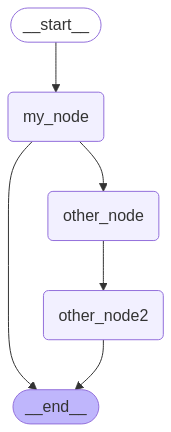

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
   pass 

## Edges

Edges define how the node is routed and how the graph decides to stop. This is big part of how your agents work and how different nodes communicate with each other. There are a few types of edges.

* `Normal Edges`: Go directly from one node to another node.
* `Conditional Edges`: Call a function to dermine which nodes to go to next.
* `Entry point`: Which node to call first when user input arrives.
* `Conditional Entry point`: Call a function to determine.

A Node can have MULTIPLE outgoing edges. If a node has multiple out-going edges, all of those destination nodes will be executed in parallel as a part of the next superstep.

* `Normal Edge`
    * If you always want to go from node A to node B you can use the `add_edge` method directly.
    
        Eg: `add_edge("node_a", "node_b")`

* `Conditional Edge`
    * If you want to add some logic based on the logic you want to route edges you can you this one. This method accept the name of a node and a "routing function" to call after the node is executed.

        Eg: `graph.add_conditional_edges("node_a", routing_function)`

    * Similar to nodes, the `routing_function` accepts the current `state` of the graph and returns a value (node value which we will describe on the func).
    * By default, the return value the `routing_function` is used as the name of the node(or list of nodes) to send the state to next. All those nodes will be run in parellel as a part of the next superstep.
    * You can optionally provide a dictionary that maps the routing_function's output to the name of the next node.

        Eg: `graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})`.

* `Entry Point`
    * The entry point is the first node(s) that are run when the graph start. You can use the `add_edge` method from the virtual `START` node to the first node to execute to specify where to enter the graph.
    
        Eg: `from langgraph.graph import START
             graph.add_edge(START, "node_a")`

* `Conditional Entry point`
    * In this we pass a conditional function based on the logic inside the function we call the node.
        Eg: `graph.add_conditional_edges(START, routing_function)`

    * You can optionally provide a dictionary that maps the routing_function's output to the name of the next node.
        Eg: `graph.add_conditional_edges(START, routing_function, {True: "node_b", False: "node_c"})`.
